<a href="https://colab.research.google.com/github/AleCongi/Esame-ICON-/blob/main/cisiamoquasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ingegneria della Conoscenza
Università degli studi di Bari "Aldo Moro", Dipartimento di Informatica.

Il seguente notebook è stato elaborato degli studenti:


*   Congedo Alessandro (mat. 677315)
*   Romano Andrea (mat. XXXXXX)

Il progetto che presentiamo è un esempio di come l'IA possa essere utilizzata per classificare eventi in base a descrizioni e categorie.

---



L'obiettivo di questo studio è quello di sviluppare un sistema di apprendimento automatico che sia in grado di rappresentare la conoscenza sia a basso livello che ad alto livello, garantendo una gestione d'incertezza.

Il progetto è stato condotto nell'ottica di arricchire il precedente lavoro dei [**BroUsers**](https://www.instagram.com/bro__users) chiamato [**OneNight**](https://t.me/wannight_bot), un **bot Telegram** che raccoglie informazioni sugli eventi in una determinata zona geografica.

---
L'esigenza di una filtrazione ulteriore degli eventi mediante delle categorie prestabilite si configura come una nuova espansione del progetto.

La passione che abbiamo per il nostro lavoro, sia quello sviluppato in passato che quello presentato, ci ha spinto a esplorare nuove soluzioni e a sviluppare un sistema che possa fornire un contributo significativo alla comunità.

**Indice delle sezioni:**


*   **A**: *CARICAMENTO E FIX DEL DATASET*
  * **A1**: *PLOT DEL DATASET*
*   **B**: *PREPROCESS DELLE DESCRIZIONI*
  * **B1**: *FUNZIONI PREPROCESSING*
  * **B2**: *PREPROCESSING*
  * **B3**: *TOKENIZATION, SEQUENCING & PADDING*
  * **B4**: *RAPPRESENTAZIONE DEL TESTO A BASSO LIVELLO*
      * **B4.1** *ALTERNATIVA EMBEDDINGS VIA WORLD2VEC*
      * **B4.2** *ALTERNATIVA FEATURE EXTRACTION VIA RETE NEURALE*
      * **B4.3** *ALTERNATIVA VECTORIZATION VIA TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY*
*   **C**: *CLASSIFICAZIONE*
*   **D**: *RETE NEURALE*
*   **E**: *LOGICHE FUZZY*
*   **F**: *RAPPRESENTAZIONE DELLA CONOSCENZA*
  * **F1**: *ONTOLOGIA: WORDNET*
  * **F2**: *RETE SEMANTICA*



In [1]:
!pip install nltk
!pip install scikit-multilearn
!pip install scikit-fuzzy
!pip install fuzzywuzzy
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 2.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 KB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=f2f587ffa1e105eacc7c58ce2abc810b6ac3a0cca27a800bd02bb4c6224b15ce
  Stored in directory: /root/.cache/pip/wheels/2c/04/80/7eefb1a2de7d36aefd06432fab2a1486caf0a0596a7067391a
Successfully built scikit-fuzzy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 

In [2]:
from google.colab import drive

import pandas as pd

import seaborn as sns

from re import sub as sub

import matplotlib.pyplot as plt

import string

import networkx as nx

from operator import pos

import random

import pickle

import gensim.downloader as api

from sys import exit as exit
import sys

import numpy as np
from numpy.ma.core import outer
from numpy import mean
from numpy import std

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as dl
from nltk import word_tokenize as tkn
from nltk import pos_tag

import stanza
from stanza.pipeline.processor import Processor

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput  import  ClassifierChain
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances,accuracy_score, average_precision_score, f1_score, hamming_loss, label_ranking_average_precision_score, precision_recall_curve, recall_score, classification_report, r2_score
from sklearn.utils import class_weight
from sklearn.metrics.pairwise import cosine_similarity

from skmultilearn.problem_transform import LabelPowerset

dl('wordnet')
dl('omw-1.4')
dl('punkt')
dl('stopwords')
dl('averaged_perceptron_tagger')
dl('tagsets')
stanza.download('it')

drive.mount('/content/drive', force_remount=False)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


INFO:stanza:Downloading default packages for language: it (Italian) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


Mounted at /content/drive


##**A**: *CARICAMENTO E FIX DEL DATASET*

In [3]:
tot=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/eventi.csv')
tot.head(10)

,culture,music,food,fun,id,text
0,0,0,0,1,1000187186721956,Martedi 05 gennaio super tombolata al Barfly!\...
1,0,1,0,1,100731190460200,"Ingresso free senza obbligo di consumazione,se..."
2,1,1,0,1,1014507045355357,"Giovedi 8 Marzo, Napulitanata ""celebra la donn..."
3,1,1,0,1,1015563648832823,yn e lieta di presentare\n\nNapoolyn x Resilie...
4,0,0,0,1,1021806692027608,Serata live \nVENERDI' 18 MARZO \nUn piacevole...
5,1,1,1,1,1023358881203820,Quest'anno in occasione di san Valentino il ri...
6,1,1,0,1,103006560538403,La 1 Esposizione dei disegni di DIPSTER accomp...
7,1,1,0,1,1033389857374299,LELIO MORRA e tornato a suonare in giro\n\nha ...
8,1,0,0,1,1033660330389424,Largo alla beneficenza! Per iniziare al megli...
9,1,1,0,1,1034778187923694,L'evento piu internazionale a Napoli! L Aperil...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


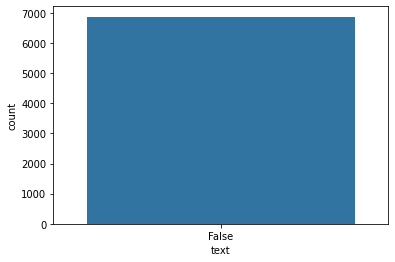

In [4]:
sns.countplot((tot["text"] == None))

Sapendo che "id" è la nostra colonna primaria, controllo che il numero di valori unici nella colonna primaria sia uguale al numero di righe. Questo mi permette di accertarmi di non avere la stessa riga per più di una volta nel mio dataset.

In [5]:
tot['id'].nunique() == len(tot['id'])

False

In [6]:
tot = tot.drop_duplicates(subset="id", keep='last')
tot = tot.drop_duplicates(subset="text", keep='last')

for index, row in tot.iterrows():  
  try:
    trashId = row['id']
    trash = row['text'].lower()
  except AttributeError as ae:
    tot.drop(tot[tot['id'] == trashId].index, inplace=True)

In [7]:
tot['id'].nunique() == len(tot['id'])

True

In [8]:
tot=tot.reset_index(drop=True)

In [9]:
tot.count()

culture    6053
music      6053
food       6053
fun        6053
id         6053
text       6053
dtype: int64

###**A1**: *PLOT DEL DATASET*

In [27]:
def getRandomIndex(df):
  return random.randint(0, len(df) - 1)

getRandomIndex(tot)

2611

Ecco i primi elementi del dataset.

In [32]:
tot

,culture,music,food,fun,id,text
0,0,0,0,1,1000187186721956,Martedi 05 gennaio super tombolata al Barfly!\...
1,0,1,0,1,100731190460200,"Ingresso free senza obbligo di consumazione,se..."
2,1,1,0,1,1014507045355357,"Giovedi 8 Marzo, Napulitanata ""celebra la donn..."
3,1,1,0,1,1015563648832823,yn e lieta di presentare\n\nNapoolyn x Resilie...
4,0,0,0,1,1021806692027608,Serata live \nVENERDI' 18 MARZO \nUn piacevole...
...,...,...,...,...,...,...
6048,1,1,0,0,996956944037551,Hot Club Roma Trio\n\nMoreno Viglione chitarra...
6049,1,0,0,0,997255064998935,"Presentazione del libro:\n ""Tasmania"" (Einaudi..."
6050,1,1,0,0,997824980996408,In occasione delle GIORNATE EUROPEE DEL PATRIM...
6051,1,0,0,1,998364400508276,Vieni a Danzare gratuitamente per un giorno co...


In [12]:
tot.dtypes

culture     int64
music       int64
food        int64
fun         int64
id          int64
text       object
dtype: object

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


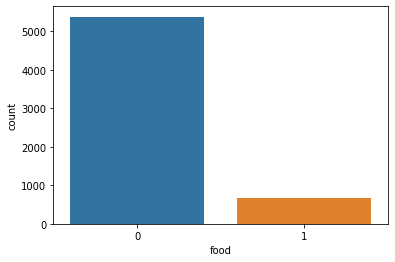

In [13]:
sns.countplot(tot['food'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


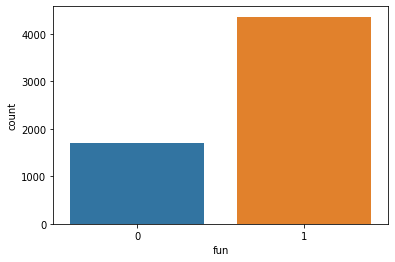

In [14]:
sns.countplot(tot['fun'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


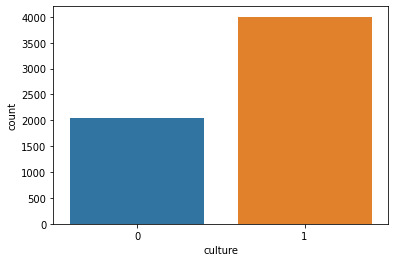

In [15]:
sns.countplot(tot['culture'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


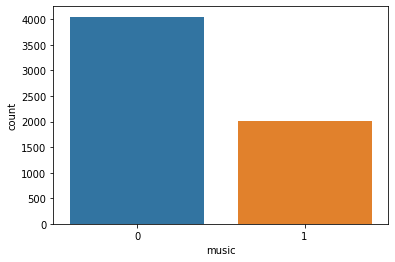

In [16]:
sns.countplot(tot['music'])

##**B**: *PREPROCESS DELLE DESCRIZIONI*

###**B1**: *FUNZIONI PREPROCESSING*

In [3]:
def remove_numbers(input_string):
    # Crea una tabella di traduzione che mappa tutti i numeri a None
    translate_table = input_string.maketrans("", "", string.digits)
    # Utilizza la tabella di traduzione per rimuovere tutti i numeri
    return input_string.translate(translate_table)

def remove_punctuation(input_string):
    for char in string.punctuation:
          input_string = input_string.replace(char, " ")
    return input_string

stnzPipe = stanza.Pipeline(lang='it', processors='tokenize,pos')

def remove_non_N_V(input_string):
    doc = stnzPipe(input_string)
    tagged_words = [word.text for sent in doc.sentences for word in sent.words if word.upos in ['NOUN', 'VERB']]
    return ' '.join(tagged_words)

def remove_non_N_V_ENG(input_string):
    words = tkn(input_string)
    tagged_words = pos_tag(words)
    nouns = [word for word, pos in tagged_words if pos in ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP','VBZ']]
    return ' '.join(nouns)

def preProcessDescription(description, stopwordsTotali, maxSeqLen = None,tokenizer = None, lang = 'ita'):
  splitted = remove_punctuation(remove_numbers(description.lower())).split()
  parole_filtrate = [parola for parola in splitted if not parola in stopwordsTotali]
  descrizione = " ".join(parole_filtrate)
  if lang == 'ita':
    descrizione_filtrata = remove_non_N_V(descrizione)
  elif lang == 'eng':
    descrizione_filtrata = remove_non_N_V_ENG(descrizione)
  if (maxSeqLen is None or tokenizer is None):
    input_data = descrizione_filtrata
  else:
    input_data = tokenizer.texts_to_sequences([descrizione_filtrata])
    input_data = pad_sequences(input_data, maxlen=maxSeqLen,padding='post')
    original_description = ""
    for i, word in enumerate(input_data[0]):
      if word == 1:
        for key, value in tokenizer.word_index.items():
          if value == i :
            original_description += key + " "
    print('Traduzione della sequenza numero in parole: ')
    print(original_description)
  return input_data

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: it (Italian):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |
| pos       | combined |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Done loading processors!


Wordnet Ontology Functions

In [114]:
#Wordnet

def get_syns(description):
  test=[]
  words = tkn(description)
  for every in words:
    if (every not in stopwordsTotali):
      if(wn.synsets(every, lang ='ita') == []):
        
          test.append(wn.synsets(every))
      else:
        
          test.append(wn.synsets(every, lang ='ita'))
      #print('parola iniziale: ',every)
      #print('synset: ',wn.synsets(every, lang ='ita'))
  lemmatizer = WordNetLemmatizer()
  out =[]
  for each in range(len(test)):
    for q in range(len(test[each])):
      wordToAdd=lemmatizer.lemmatize(test[each][q].name().split('.')[0])
      out.append(wordToAdd)
      if(q==1):
        #print(out)
        break
  #out=test
  out=list(set(out))
  return out

def reduced_description(description):
    # Tokenize the description
    tokens = tkn(description)
    # Reduce the words to their most common synset
    reduced_description = []
    for token in tokens:
      try:
          synset = wn.synsets(token, lang='ita',pos=wn.NOUN)
          if(synset == []):
            synset = wn.synsets(token, lang='ita',pos=wn.VERB)
            if(synset == []):
              synset = wn.synsets(token, lang='eng',pos=wn.NOUN)
              if(synset == []):
                synset = wn.synsets(token, lang='eng',pos=wn.VERB)  
          lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
          reduced_description.append(lemma)
      except:
          continue
    return list(set(reduced_description))


def predict_closest_clusters(df, description, km, X, vectorizerTfIdf):

    description=reduced_description(description)

    newWords = ''
    
    for each in description:
      newWords = newWords + ' ' + each
    description=newWords

    # Transform the input description into a tf-idf representation
    input_tfidf = vectorizerTfIdf.transform([description])

    # Calculate the distances between the input and each of the 10 clusters
    cluster_distances = km.transform(input_tfidf).flatten()

    # Get the index of the closest cluster
    closest_cluster_index = np.argmin(cluster_distances)

    print("Il cluster più vicino è il cluster numero: ", closest_cluster_index)

    terms = vectorizerTfIdf.get_feature_names()
    top_ten_words = [terms[ind] for ind in order_centroids[closest_cluster_index, :5]]
    print("Le sue parole più rilevanti sono: {}".format(', '.join(top_ten_words)))
    
    # Calculate the distances between the input and each sample in X
    sample_distances = pairwise_distances(input_tfidf, X).flatten()
    # Get the indices of the 5 closest samples
    closest_sample_indices = sample_distances.argsort()
    print("I 5 eventi più importanti nel dataset sono:")
    count = 0
    for i in closest_sample_indices: 
      if (len(df['text'][i]) > 100):
        print(df['text'][i])
        count = count + 1
      if (count == 5):
        break

###**B2**: *PREPROCESSING*

In [5]:
stp = open("/content/drive/MyDrive/Colab Notebooks/stopwordsita.txt", "r")
data = stp.read().split("\n")
stp.close()
stopwordsTotali = stopwords.words('italian') + stopwords.words('english') + data
stopwordsTotali = list(set(stopwordsTotali).union(['il', 'lo', 'la', 'i', 'gli', 'le', 'una', 'un', 'uno', 'di', 'a', 'da', 'in', 'con', 'su', 'per', 'tra', 'fra', 'www', 'http', 'https', 'it','com']))

In [6]:
'https' in stopwordsTotali

True

In [31]:
descrizioni_filtrate = []
count = 1
for index, evento in tot.iterrows():
  descrizione_filtrata=preProcessDescription(evento['text'],stopwordsTotali)
  if(count%20 == 0):
    print(descrizione_filtrata)
  descrizioni_filtrate.append(descrizione_filtrata)
  count = count + 1

club indirizzo info
masterclass degustazione vodka standard evento prenotazione standard relatrice esperienza mondo vodka
accreditato provider mp srl congressi comunicazione professioni medico chirurgo discipline iscrizione iscriver scuolaecografiaclinicagragnano iscrizioni
serata musica gruppo valetodovoice carrellata brani italiani chiave elettro acustica cantare ballare voce vale todo prenotazione prenota link chiama qualita professionalita servizio venerdisera biergrube big paninoteca pub braceria birreria amore famiglia discopub glutenfree
mostra artista
continua divertimento barfly successo settimna ritorna richiesta tombolata premi show monfregola consumazione carta panini sfizi taglieri carne griglia hamburger gourmet chianina prenotazione barfly parcheggio
evento lascera fiato parco benessere monte sorprese aspettano mercatini area shopping area food incontro babbo animazione giochi elfi zucchero filato pop corn babbo aspetta porta bambini letterine clause parco benessere prin

In [33]:
np.savetxt('/content/drive/MyDrive/Colab Notebooks/descrizioni_filtrate.txt', np.array(descrizioni_filtrate), fmt='%s')

#descrizioni_filtrate_loaded = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/descrizioni_filtrate.txt', dtype=str)

In [34]:
ix = getRandomIndex(tot)
print(descrizioni_filtrate[ix])
print('\n\n')
print(tot['text'][ix])

serata tributo biergrube ritorno casa biergrube porteremo anni hit wham simphonica pop star fans amici perdere spettacolo aspettiamo condividere passione clicca link prenotazione tinyurl prenotazioni



Serata live TRIBUTO GEORGE MICHAEL FREEDOMGROUP
VENERDI' 21 OTTOBRE  AT/ 
21 BIERGRUBE 
Un piacevole ritorno, in casa BIERGRUBE.
vi porteremo negli anni 80/90 con le migliori hit da i WHAM A SIMPHONICA ...DELLA POP STAR LONDINESE
cari fans, amici non potete perdere lo spettacolo del 21 OTTOBRE ..
Vi aspettiamo a condividere con noi la grande passione del mr. GEORGE MICHAEL
------------------------------
clicca il link, per la tua prenotazione. 
https://tinyurl.com/237mk9b9
VIA PIAVE 21 , NAPOLI, ITALY
PRENOTAZIONI, INF..376 0753631- 081 714 1336.. 
..


In [71]:
words = ['festa', 'cantare', 'bello', 'comunque']
for parola in words:
  doc = stnzPipe(parola)
  print(parola + ' è un: '+doc.sentences[0].words[0].upos)

festa è un: NOUN
cantare è un: VERB
bello è un: ADJ
comunque è un: ADV


In [36]:
corpus = descrizioni_filtrate

In [37]:
type(corpus)

list

In [38]:
print(len(tot['text']) == len(corpus))

True


In [39]:
tot['filtered_desc']=corpus

In [7]:
tot.to_csv(r'/content/drive/MyDrive/Colab Notebooks/eventiDescrizioniFiltrate.csv', index = False)

NameError: ignored

In [ ]:
X1 = []
newText=corpus

for description in newText:   
    feature =[]
    features = reduced_description(str(description))
    words = ''
    for each in features:
      words = words + ' ' + each
    X1.append(words)

In [41]:
tot['wordnet_desc']=X1

In [132]:
inx=7
print(corpus[inx])
print(X1[inx])

beneficenza iniziare anno centro birreria supporta associazioni protagonista diamounamano ultras raccolto giocattoli regalati famiglie bambini bisogno richiedere coupon ritirare giocattoli contattare associazione protagonista mail sede
 charity require reach toddler grade coupon protagonist hide motive alehouse hit mail crop headquarters begin association


In [18]:
#tot.to_csv(r'/content/drive/MyDrive/Colab Notebooks/eventiDescrizioniFiltrateWordNet.csv', index = False)
tot=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/eventiDescrizioniFiltrateWordNet.csv', keep_default_na=False)

In [19]:
tot

,culture,music,food,fun,id,text,filtered_desc,wordnet_desc
0,0,0,0,1,1000187186721956,Martedi 05 gennaio super tombolata al Barfly!\...,tombolata calze vincere formula panino patatin...,win rule soft_drink briefcase booking french_...
1,0,1,0,1,100731190460200,"Ingresso free senza obbligo di consumazione,se...",ingresso obbligo consumazione serata disco bar,consummation entrance discus bar evening resp...
2,1,1,0,1,1014507045355357,"Giovedi 8 Marzo, Napulitanata ""celebra la donn...",celebra donna serata eccezione magia sax jazzi...,irregularity booking museum entrance result r...
3,1,1,0,1,1015563648832823,yn e lieta di presentare\n\nNapoolyn x Resilie...,presentare napoolyn resilienza records resilie...,joining record_player brother festival entran...
4,0,0,0,1,1021806692027608,Serata live \nVENERDI' 18 MARZO \nUn piacevole...,serata ritorno palco biergrube porteremo anni ...,fan headliner passion tribute booking share w...
...,...,...,...,...,...,...,...,...
6048,1,1,0,0,996956944037551,Hot Club Roma Trio\n\nMoreno Viglione chitarra...,club trio chitarra solista chitarra gattone co...,clubhouse guitarist project dancing trio film...
6049,1,0,0,0,997255064998935,"Presentazione del libro:\n ""Tasmania"" (Einaudi...",presentazione libro editore dialoga autore pos...,leak change voice actor future novel demonstr...
6050,1,1,0,0,997824980996408,In occasione delle GIORNATE EUROPEE DEL PATRIM...,occasione giornate patrimonio ore museo parco ...,roentgen museum entrance quintet information ...
6051,1,0,0,1,998364400508276,Vieni a Danzare gratuitamente per un giorno co...,danzare giorno amici tagga locandina lm scuola...,hop morning clubhouse dance lumen dancing win...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


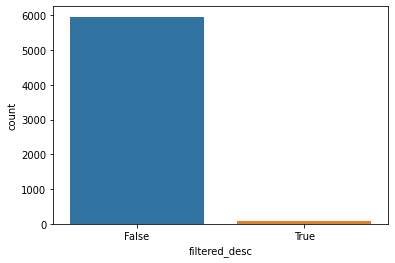

In [20]:
sns.countplot((tot["filtered_desc"] == '' ))

In [21]:
for index, row in tot.iterrows():
  if row['filtered_desc'] == '':
    tot.at[index, "filtered_desc"] = preProcessDescription(row['text'], stopwordsTotali, lang='eng')
    features = reduced_description(str(row['filtered_desc']))
    words = ''
    for each in features:
      words = words + ' ' + each
    tot.at[index, "wordnet_desc"] = words

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


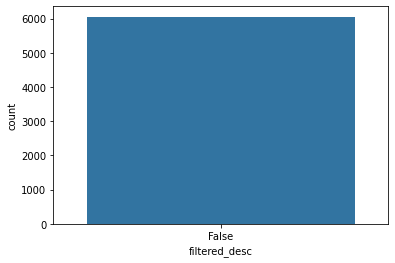

In [14]:
sns.countplot((tot["filtered_desc"] == '' ))

In [23]:
tot['filtered_desc'][699]

'records rilis producers meeting n dance records store amsterdam th edition meetings focus stay gathering friends discovering talents r capuano audiomatiques meets producers demo submissions edition see appearances stage beico mt taboada spektre stiv hey dont scared reserve face face meeting sending email info looseclub ff meeting reserved visuals digitalistik hu'

In [22]:
tot['wordnet_desc'][699]

''

In [24]:
corpus = tot['filtered_desc']

###**B3**: *TOKENIZATION, SEQUENCING & PADDING*

In [28]:
MAX_NB_WORDS = 30000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
seq_lens = [len(s) for s in sequences]

In [29]:
sampleIndex = getRandomIndex(tot)
print('Sequenza descrizione numero %s: ' % sampleIndex)
for x in sequences[sampleIndex]:
  print('%d ' % x, end =' ')

Sequenza descrizione numero 5934: 
4227  1623  4552  65  1239  591  433  610  231  10912  2626  4227  574  1462  3061  309  2490  7015  16537  2000  638  1928  2469  224  1378  401  2000  908  144  14760  1694  4371  578  84  241  1623  16123  309  3556  6044  46  553  1236  144  578  74  578  144  16537  618  855  25  433  710  41  3526  5608  2614  669  942  673  61  15  129  3061  838  2380  391  210  488  638  585  2469  1578  1615  966  1389  1213  8730  4088  3826  314  7015  917  307  59  1378  597  144  2490  9121  123  1930  144  4088  16145  838  85  61  15  129  3061  1378  597  421  6602  3178  46  123  1930  597  578  342  737  585  1236  3826  497  117  4227  710  16179  85  1212  71  495  12176  591  433  373  1236  14326  1607  2272  6539  300  18  622  217  505  150  574  118  31  78  102  4227  1623  4552  269  69  78  4295  2259  109  9633  4816  4401  9634  1089  122  355  574  62  15  2796  1285  4227  4447  9120  7752  3553  44  43  1173  65  322  869  67  926  9 

In [30]:
print('Traduzione della sequenza numero %d in parole: ' % sampleIndex)
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in sequences[sampleIndex]])

Traduzione della sequenza numero 5934 in parole: 


'channelling fonte sorgente arte comunicare spirito guida maestri luce risveglia semplicita channelling seminario iniziera cerchio tecniche meditazione visualizzazioni inizierai riconoscere radici albero essenza qualita aprire porte riconoscere potere cuore fragranza frequenza grandezza mente stato servizio fonte useremo tecniche stimolare attivare centro accedere silenzio cuore mente spazio mente cuore inizierai prendere contatto voce guida scrittura programma end subire variazioni arrivo accoglienza segreteria inizio corso apertura cerchio condivisione presentazioni cose scoprire forza radici dialogo essenza alberi fiore ascolto sentire fiducia pulizia chakra break movimento visualizzazioni creativita colori danza aprire dimensione cuore meditazione osho pranzo esplorare cuore chakra ritual condivisione gruppo inizio corso apertura cerchio aprire dimensione maestro zen esplorazione centro pranzo esplorare dimensione mente forme pensiero dialogo silenzio break tecnica base channelling

Text(0.5, 1.0, 'Y documenti con X parole')

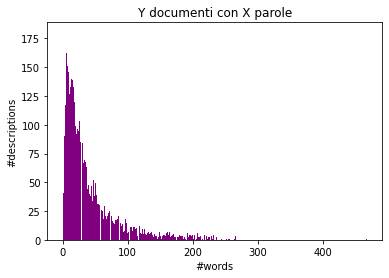

In [31]:
%matplotlib inline

plt.hist(seq_lens, bins=500, color = 'purple')
plt.xlabel('#words')
plt.ylabel('#descriptions')
plt.title('Y documenti con X parole')

In [32]:
media=np.mean(seq_lens)
print("average length: %0.1f" % media)
print("max length: %d" % max(seq_lens))
y = 0
for i in seq_lens:
  if i < media:
    y = y + 1

print("percentuale descrizioni di lunghezza inferiore ad average length: %d%%" % (int(y*100/len(seq_lens))))


average length: 42.1
max length: 468
percentuale descrizioni di lunghezza inferiore ad average length: 67%


La lunghezza media dei testi è di circa 65: eseguo il pad con massima lunghezza 70, valutando che la maggior parte delle descrizioni non supera quel numero di parole.

In [33]:
MAX_SEQUENCE_LENGTH = 70

# pad sequences with 0s
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

print('Shape of data tensor:', padded.shape)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Shape of data tensor: (6053, 70)
Found 32708 unique tokens.


In [34]:
padded[sampleIndex].shape[0]

70

In [35]:
preProcessDescription('techno rave party festa scuola',stopwordsTotali, MAX_SEQUENCE_LENGTH, tokenizer)

Traduzione della sequenza numero in parole: 



array([[145,  57,  87,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0]], dtype=int32)

###**B4**: *RAPPRESENTAZIONE DEL TESTO A BASSO LIVELLO*

####**B4.1**: *ALTERNATIVA EMBEDDINGS VIA WORLD2VEC*


In [36]:
# Download the models (1660MB)
word2vec_model300 = api.load('word2vec-google-news-300')

[=-------------------------------------------------] 2.5% 41.0/1662.8MB downloaded

KeyboardInterrupt: ignored

In [ ]:
#word2vec_model300.save("/content/drive/MyDrive/Colab Notebooks/word2vec.bin")

In [ ]:
'''x_emb = []
for sentence in padded:
  print('sentence')
  print(sentence)
  sent_emb = [0 for k in range(300)] 
  
  num_tok = 0
  for tok in sentence:
    if tok != 0:
      word=list(word_index.keys())[list(word_index.values()).index(tok)]
      print('word: '+ word)
      try:
          emb = word2vec_model300.wv[word]
          sent_emb = [x + y for x, y in zip(sent_emb, emb)]
          num_tok = num_tok +1
      except:
          pass
  if num_tok != 0:
    final_sent_emb = [x / num_tok for x in sent_emb]         
  x_emb.append(final_sent_emb)
  

x_emb = np.array(x_emb)
with open('/content/drive/MyDrive/Colab Notebooks/embeddingsSafe.npy', 'wb') as f:
    np.save(f, x_emb)'''

In [37]:
with open('/content/drive/MyDrive/Colab Notebooks/embeddings.npy', 'rb') as f:
    x_emb = np.load(f)
print(type(x_emb))
print(x_emb.shape)

<class 'numpy.ndarray'>
(6053, 300)


In [38]:
x_emb.shape

(6053, 300)

In [39]:
print(x_emb[sampleIndex])

[ 0.01342031  0.08079629  0.03047582  0.12149208 -0.04823946  0.05143979
  0.03657692 -0.05931172  0.02312269  0.06291761 -0.02775975 -0.04507607
 -0.05023836  0.04254472 -0.08012792  0.08777177  0.05775853  0.05550023
  0.00700285 -0.08294999 -0.02389045  0.05263479  0.04948024  0.03729971
 -0.09472014 -0.04100599 -0.01436414  0.10258082 -0.0094219  -0.01385659
 -0.05984392  0.0658738   0.0275903  -0.09093917 -0.04995728 -0.0970459
  0.00159173  0.05423295  0.04431313 -0.05964741 -0.00945724 -0.04368672
  0.07085539  0.14216694 -0.03918778 -0.14687127 -0.03694233  0.01545956
 -0.02264143  0.12719727 -0.09763055  0.16763466 -0.01211949  0.03469608
 -0.03412508  0.13635896 -0.07114129 -0.06212736  0.04624698 -0.09151097
 -0.14913137  0.01710269 -0.0931268  -0.04737633  0.02028937 -0.06701981
 -0.08628765 -0.07771623  0.0970973   0.12388852  0.02179758  0.04172235
 -0.0125363  -0.00554777 -0.11981201 -0.10377904  0.06805099 -0.06218278
  0.00756354 -0.01700632  0.02620215 -0.05884713 -0.

####**B4.2**: *ALTERNATIVA FEATURE EXTRACTION VIA RETE NEURALE*

In [40]:
embedding_size = 1000

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_size, input_length=MAX_SEQUENCE_LENGTH))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

token_matrix = model.predict(padded)

190/190 [==============================] - 4s 15ms/step


####**B4.3**: *ALTERNATIVA VECTORIZATION VIA TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY*

In [41]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(corpus)

##**C**: *CLASSIFICAZIONE*

In [42]:
y = tot[['culture', 'music', 'food', 'fun']]

####Split

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [ ]:
#X_trainEmb,X_testEmb,y_trainEmb,y_testEmb = train_test_split(x_emb,y,test_size=0.25,random_state=42)

In [44]:
X_trainTM,X_testTM,y_trainTM,y_testTM = train_test_split(token_matrix,y,test_size=0.25,random_state=42)

###Pesi

In [45]:
weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)
#weightsEmb = class_weight.compute_sample_weight(class_weight="balanced", y=y_trainEmb)
weightsTM = class_weight.compute_sample_weight(class_weight="balanced", y=y_trainTM)

In [46]:
pca = PCA (70)

reduced = pca.fit_transform(x_emb)

X_trainEmb,X_testEmb,y_trainEmb,y_testEmb = train_test_split(reduced,y,test_size=0.25,random_state=42)
reduced.shape

(6053, 70)

###Classificazione

Ora utilizzeremo la tecnica di classificazione a multipli riferimenti (OneVsRest) in quanto il nostro dataset risulta sbilanciato. È buona norma utilizzare questo tipo di classificazione sui dataset sbilanciati perché si addestra un classificatore per ogni classe: ogni classificatore è responsabile della distinzione tra la sua classe specifica e tutte le altre (appunto One vs Rest). Questo significa che ogni classificatore può concentrarsi sulle proprietà distintive della classe stessa

In [47]:
classificatori = [OneVsRestClassifier, ClassifierChain, LabelPowerset]
estimatori =[DecisionTreeClassifier(),RandomForestClassifier(), SVC()]
#prova anche uno fra logistic reg e sdgclassifier
param_grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [None, 5, 10],
    'estimator__min_samples_split': [2, 10],
    'estimator__min_samples_leaf': [1, 4]
}

In [48]:
def atlas (estimatori, classificatori, x_train, x_test, y_train, y_test, parametri = None):
  results = []
  for ml in classificatori:
    for each in estimatori:
      clf = ml(each)
      if (parametri is None):
          clf.fit(x_train, y_train)
          y_pred = clf.predict(x_test)
      else:
        try:
          grid_search = GridSearchCV(clf, parametri, cv=5, scoring='accuracy')
          grid_search.fit(x_train, y_train)
          best_clf = grid_search.best_estimator_
          y_pred = best_clf.predict(x_test)
        except:
          clf.fit(x_train, y_train)
          y_pred = clf.predict(x_test)
      print('\n\n')
      print(str(ml) + ' con ' + str(each) + ':\n\n')
      try:
        print('Accuracy: %0.5f' % accuracy_score(y_test,y_pred))
      except:
        try:
          print('Accuracy: %0.5f' % accuracy_score(y_test,y_pred.toarray()))
        except:
          print('skip')
          continue
      try:
        print('Loss di hamming: %0.5f' % hamming_loss(y_test,y_pred))
      except:
        try:
          print('Loss di hamming: %0.5f' % hamming_loss(y_test,y_pred.toarray()))
        except:
          print('skip')
          continue
      try:
        print('Label ranking Average-Precision: %0.5f' % label_ranking_average_precision_score(y_test,y_pred))
      except:
        try:
          print('Label ranking Average-Precision: %0.5f' % label_ranking_average_precision_score(y_test,y_pred.toarray()))
        except:
          print('skip')
          continue
      results.append([str(ml), str(each), y_pred])
  return results

In [49]:
print('Eseguo classificazione su Embeddings (Word2Vec)\n')
risultatiEmb = atlas(estimatori, classificatori, X_trainEmb, X_testEmb, y_trainEmb, y_testEmb, param_grid)

Eseguo classificazione su Embeddings (Word2Vec)




<class 'sklearn.multiclass.OneVsRestClassifier'> con DecisionTreeClassifier():


Accuracy: 0.31902
Loss di hamming: 0.24554
Label ranking Average-Precision: 0.71720



<class 'sklearn.multiclass.OneVsRestClassifier'> con RandomForestClassifier():


Accuracy: 0.46169
Loss di hamming: 0.16694
Label ranking Average-Precision: 0.79807



<class 'sklearn.multiclass.OneVsRestClassifier'> con SVC():


Accuracy: 0.51717
Loss di hamming: 0.14647
Label ranking Average-Precision: 0.81198



<class 'sklearn.multioutput.ClassifierChain'> con DecisionTreeClassifier():


Accuracy: 0.33487
Loss di hamming: 0.25281
Label ranking Average-Precision: 0.72655



<class 'sklearn.multioutput.ClassifierChain'> con RandomForestClassifier():


Accuracy: 0.49868
Loss di hamming: 0.16166
Label ranking Average-Precision: 0.81728



<class 'sklearn.multioutput.ClassifierChain'> con SVC():


Accuracy: 0.52246
Loss di hamming: 0.15571
Label ranking Average-Precision

In [50]:
print('Eseguo classificazione su matrice di token (feature Neural Network)\n')
risultatiNN = atlas(estimatori, classificatori, X_trainTM, X_testTM, y_trainTM, y_testTM, param_grid)

Eseguo classificazione su matrice di token (feature Neural Network)




<class 'sklearn.multiclass.OneVsRestClassifier'> con DecisionTreeClassifier():


Accuracy: 0.19551
Loss di hamming: 0.35832
Label ranking Average-Precision: 0.65617



<class 'sklearn.multiclass.OneVsRestClassifier'> con RandomForestClassifier():


Accuracy: 0.19419
Loss di hamming: 0.35799
Label ranking Average-Precision: 0.65491



<class 'sklearn.multiclass.OneVsRestClassifier'> con SVC():


Accuracy: 0.18494
Loss di hamming: 0.26998
Label ranking Average-Precision: 0.69006



<class 'sklearn.multioutput.ClassifierChain'> con DecisionTreeClassifier():


Accuracy: 0.19485
Loss di hamming: 0.35832
Label ranking Average-Precision: 0.65606



<class 'sklearn.multioutput.ClassifierChain'> con RandomForestClassifier():


Accuracy: 0.19287
Loss di hamming: 0.35849
Label ranking Average-Precision: 0.65502



<class 'sklearn.multioutput.ClassifierChain'> con SVC():


Accuracy: 0.20674
Loss di hamming: 0.38061
Label ranki

In [51]:
print('Eseguo classificazione su vettori Tf-Idf\n')
#risultatiTfIdf = atlas(estimatori, classificatori, X_train, X_test, y_train, y_test, param_grid)
risultatiTfIdf = atlas(estimatori, classificatori, X_train, X_test, y_train, y_test)

Eseguo classificazione su vettori Tf-Idf




<class 'sklearn.multiclass.OneVsRestClassifier'> con DecisionTreeClassifier():


Accuracy: 0.55020
Loss di hamming: 0.14036
Label ranking Average-Precision: 0.82033



<class 'sklearn.multiclass.OneVsRestClassifier'> con RandomForestClassifier():


Accuracy: 0.62550
Loss di hamming: 0.11460
Label ranking Average-Precision: 0.86665



<class 'sklearn.multiclass.OneVsRestClassifier'> con SVC():


Accuracy: 0.61691
Loss di hamming: 0.11179
Label ranking Average-Precision: 0.86076



<class 'sklearn.multioutput.ClassifierChain'> con DecisionTreeClassifier():


Accuracy: 0.54293
Loss di hamming: 0.15654
Label ranking Average-Precision: 0.82161



<class 'sklearn.multioutput.ClassifierChain'> con RandomForestClassifier():


Accuracy: 0.67569
Loss di hamming: 0.10139
Label ranking Average-Precision: 0.88792



<class 'sklearn.multioutput.ClassifierChain'> con SVC():


Accuracy: 0.67305
Loss di hamming: 0.10568
Label ranking Average-Precision: 0.888

####VariousPlots

<class 'sklearn.multioutput.ClassifierChain'> + SVC():



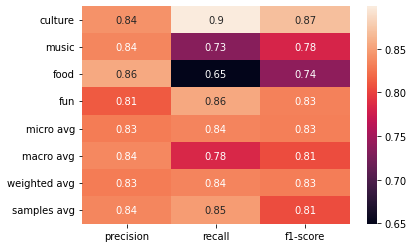

In [52]:
print(risultatiEmb[5][0] + ' + ' + risultatiEmb[5][1] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,risultatiEmb[5][2], zero_division=1, output_dict=True, target_names=['culture', 'music','food','fun'])).iloc[:-1, :].T, annot=True, linecolor='purple')

<class 'skmultilearn.problem_transform.lp.LabelPowerset'> + SVC():



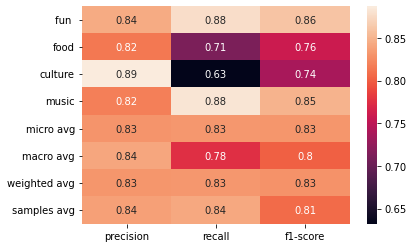

In [53]:
print(risultatiEmb[8][0] + ' + ' + risultatiEmb[8][1] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,risultatiEmb[8][2], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

<class 'sklearn.multiclass.OneVsRestClassifier'> + DecisionTreeClassifier():



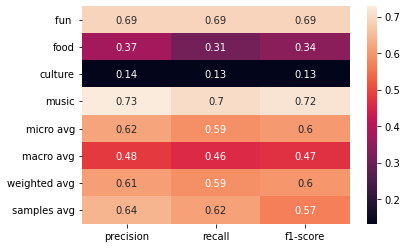

In [54]:
print(risultatiNN[0][0] + ' + ' + risultatiNN[0][1] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,risultatiNN[0][2], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

<class 'skmultilearn.problem_transform.lp.LabelPowerset'> + SVC():



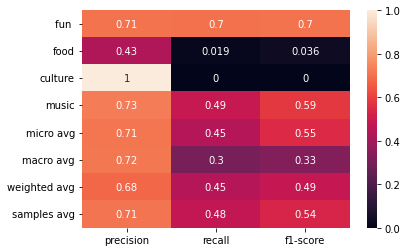

In [55]:
print(risultatiNN[8][0] + ' + ' + risultatiNN[8][1] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,risultatiNN[8][2], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

<class 'sklearn.multioutput.ClassifierChain'> + RandomForestClassifier():



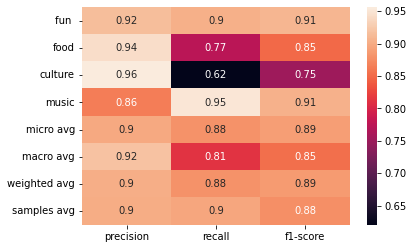

In [56]:
print(risultatiTfIdf[4][0] + ' + ' + risultatiTfIdf[4][1] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,risultatiTfIdf[4][2], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

<class 'skmultilearn.problem_transform.lp.LabelPowerset'> + SVC():



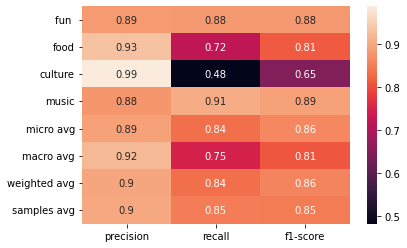

In [57]:
print(risultatiTfIdf[8][0] + ' + ' + risultatiTfIdf[8][1] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,risultatiTfIdf[8][2], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

###Trasformazione del dataset in valori discreti

Procediamo con il trasformare il dataset in valori discreti (da 0 a 1) per mezzo del Logistic Regression Classifier.

N.B. La somma di probabilità per ogni riga è 1

In [60]:
target_variables = ["culture", "music", "food", "fun"]

models = []
for target in target_variables:
    clf = LogisticRegression(random_state=0)
    clf.fit(X, tot[target])
    models.append(clf)

# Generate probability estimates for each target variable
probabilities = np.zeros((tot.shape[0], len(target_variables)))
for i, clf in enumerate(models):
    probabilities[:, i] = clf.predict_proba(vectorizer.fit_transform(tot["filtered_desc"]))[:, 1]

# Normalize the probabilities so that they sum up to 1 for each sample
probabilities /= probabilities.sum(axis=1, keepdims=True)

# Creare un nuovo dataset con le probabilità
new_df = pd.DataFrame(probabilities, columns=target_variables)

# Aggiungere le descrizioni come nuova colonna
new_df["filtered_desc"] = tot["filtered_desc"]
new_df["wordnet_desc"] = tot["wordnet_desc"]
new_df["text"] = tot["text"]
new_df["id"]=tot["id"].astype(str)
# Salvare il nuovo dataset
#new_df.to_csv("probabilities.csv", index=False)

In [61]:
new_df

,culture,music,food,fun,filtered_desc,wordnet_desc,text,id
0,0.262411,0.064499,0.062840,0.610250,tombolata calze vincere formula panino patatin...,win rule soft_drink briefcase booking french_...,Martedi 05 gennaio super tombolata al Barfly!\...,1000187186721956
1,0.213070,0.371455,0.036840,0.378635,ingresso obbligo consumazione serata disco bar,consummation entrance discus bar evening resp...,"Ingresso free senza obbligo di consumazione,se...",100731190460200
2,0.321324,0.294456,0.029148,0.355073,celebra donna serata eccezione magia sax jazzi...,irregularity booking museum entrance result r...,"Giovedi 8 Marzo, Napulitanata ""celebra la donn...",1014507045355357
3,0.364235,0.301999,0.007597,0.326169,presentare napoolyn resilienza records resilie...,joining record_player brother festival entran...,yn e lieta di presentare\n\nNapoolyn x Resilie...,1015563648832823
4,0.262902,0.240395,0.022302,0.474401,serata ritorno palco biergrube porteremo anni ...,fan headliner passion tribute booking share w...,Serata live \nVENERDI' 18 MARZO \nUn piacevole...,1021806692027608
...,...,...,...,...,...,...,...,...
6048,0.373870,0.447138,0.008919,0.170073,club trio chitarra solista chitarra gattone co...,clubhouse guitarist project dancing trio film...,Hot Club Roma Trio\n\nMoreno Viglione chitarra...,996956944037551
6049,0.635756,0.069304,0.014605,0.280335,presentazione libro editore dialoga autore pos...,leak change voice actor future novel demonstr...,"Presentazione del libro:\n ""Tasmania"" (Einaudi...",997255064998935
6050,0.470842,0.332995,0.013837,0.182326,occasione giornate patrimonio ore museo parco ...,roentgen museum entrance quintet information ...,In occasione delle GIORNATE EUROPEE DEL PATRIM...,997824980996408
6051,0.445390,0.079678,0.016303,0.458629,danzare giorno amici tagga locandina lm scuola...,hop morning clubhouse dance lumen dancing win...,Vieni a Danzare gratuitamente per un giorno co...,998364400508276


In [ ]:
tot

In [71]:
# Prevedi le etichette per un nuovo evento

new_events = ['concerto rock stasera', 'partita di calcio con amici', 'cena al lume di candela', 'presentazione del libro']
for each in new_events:
  X_new = vectorizer.transform([each])

  y_pred_fun = models[0].predict_proba(X_new)[0][1]
  y_pred_food = models[1].predict_proba(X_new)[0][1]
  y_pred_culture = models[2].predict_proba(X_new)[0][1]
  y_pred_music = models[3].predict_proba(X_new)[0][1]

  # Confronta i risultati per evincere la categoria di appartenenza dell'evento
  probs = [y_pred_fun, y_pred_food, y_pred_culture, y_pred_music]
  pred_class = ['culture', 'music', 'food', 'fun'][np.argmax(probs)]
  print('"'+each+'"' + f" belongs to the {pred_class} class with a probability of {np.max(probs):.2f}")

"concerto rock stasera" belongs to the music class with a probability of 0.84
"partita di calcio con amici" belongs to the fun class with a probability of 0.86
"cena al lume di candela" belongs to the food class with a probability of 0.51
"presentazione del libro" belongs to the culture class with a probability of 0.98


##**D**: *RETE NEURALE*

In [88]:
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dense(256, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(n_outputs, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
  return model

def evaluate_model(X_train, y_train, X_test, y_test):
  results = list()
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  model = get_model(X_train.shape[1], y_train.shape[1])
  fit=model.fit(X_train, y_train, verbose=1, epochs=60)
  yhat = model.predict(X_test)
  acc = accuracy_score(y_test.round(), yhat.round())
  print('>%.3f' % acc)
  results.append(acc)
  print(yhat)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
  # Plot training and validation accuracy
  ax1.plot(fit.history['accuracy'])
  ax1.set_title('Model Accuracy')
  ax1.set_ylabel('Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  # Plot training and validation loss
  ax2.plot(fit.history['loss'])
  ax2.set_title('Model Loss')
  ax2.set_ylabel('Loss')
  ax2.set_xlabel('Epoch')
  ax2.legend(['train', 'validation'], loc='upper left')
  
  plt.show()
  return results,model

Epoch 1/60
142/142 [==============================] - 1s 2ms/step - loss: 0.5248 - accuracy: 0.3651
Epoch 2/60
142/142 [==============================] - 0s 3ms/step - loss: 0.3865 - accuracy: 0.6041
Epoch 3/60
142/142 [==============================] - 0s 3ms/step - loss: 0.3485 - accuracy: 0.6191
Epoch 4/60
142/142 [==============================] - 0s 3ms/step - loss: 0.3305 - accuracy: 0.6352
Epoch 5/60
142/142 [==============================] - 0s 3ms/step - loss: 0.3184 - accuracy: 0.6464
Epoch 6/60
142/142 [==============================] - 1s 4ms/step - loss: 0.3099 - accuracy: 0.6512
Epoch 7/60
142/142 [==============================] - 0s 3ms/step - loss: 0.3012 - accuracy: 0.6568
Epoch 8/60
142/142 [==============================] - 1s 4ms/step - loss: 0.2934 - accuracy: 0.6631
Epoch 9/60
142/142 [==============================] - 0s 3ms/step - loss: 0.2864 - accuracy: 0.6640
Epoch 10/60
142/142 [==============================] - 0s 3ms/step - loss: 0.2813 - accuracy: 0.6700

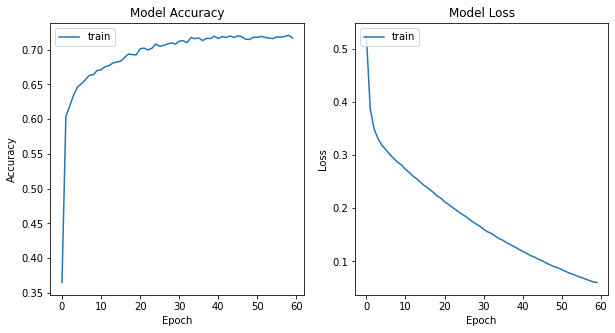

Accuracy Embeddings word2vec: 0.509 (0.000)


In [89]:
# evaluate model
#results,model = evaluate_model(X_train, y_train, X_test, y_test)
# summarize performance
#print('Accuracy tfidf: %.3f (%.3f)' % (mean(results), std(results)))

# evaluate model
#resultsTM,modelTM = evaluate_model(X_trainTM, y_trainTM, X_testTM, y_testTM)
# summarize performance
#print('Accuracy matrice di token NN: %.3f (%.3f)' % (mean(resultsTM), std(resultsTM)))

# evaluate model
resultsEmb,modelEmb = evaluate_model(X_trainEmb, y_trainEmb, X_testEmb, y_testEmb)
# summarize performance
print('Accuracy Embeddings word2vec: %.3f (%.3f)' % (mean(resultsEmb), std(resultsEmb)))

##**E**: *LOGICHE FUZZY*

Vogliamo tramite regole fuzzy determinare se un evento si svolgerà di notte o meno

In [90]:
from skfuzzy import control as ctrl
from fuzzywuzzy import fuzz

/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [91]:
def is_night_event(event_vector, night_vector, threshold=25):
  similarity = fuzz.token_set_ratio(event_vector, night_vector)
  if similarity >= threshold:
    return True
  else:
    return False

Deduco la costruzione della regola da delle stime probabilistiche effettuate sul dataset

In [92]:
def categorize_text(df, string):
  words = string.split()
  result = [0, 0, 0, 0]
  count = 0
  for index, row in tot.iterrows():
    for word in words:
      if word in row['text']:
        result[0] = result[0] + row['fun']
        result[1] = result[1] + row['food']
        result[2] = result[2] + row['culture']
        result[3] = result[3] + row['music']
        count = count + 1
        break
  result[0] = result[0] / count
  result[1] = result[1] / count
  result[2] = result[2] / count
  result[3] = result[3] / count
  return result
#questi rappresentano i valori medi su cui definiremo la regola
valoriNotte=categorize_text(tot,'notte')
valoriNotte

[0.9403508771929825,
 0.24210526315789474,
 0.6807017543859649,
 0.6175438596491228]

estrae il vettore delle feature per quell'evento

In [93]:
def get_event_vector(event_tuple):
    event_vector = []
    for header in ['fun', 'food', 'culture', 'music']:
        event_vector.append(event_tuple[header])
    return event_vector

In [94]:
event_vector=get_event_vector(new_df.iloc[0])
event_vector

[0.6102501378826924,
 0.06283969933125853,
 0.26241114750940653,
 0.06449901527664262]

In [95]:
result = is_night_event(event_vector, valoriNotte)
if result:
  print("L'evento è di notte")
else:
  print("L'evento non è di notte")

L'evento è di notte


In [96]:
tag=[]
for index, row in new_df.iterrows():
    event_vector=get_event_vector(new_df.iloc[index])
    tag.append(is_night_event(event_vector, valoriNotte))

new_df['atNight'] = tag

In [97]:
new_df

,culture,music,food,fun,filtered_desc,wordnet_desc,text,id,atNight
0,0.262411,0.064499,0.062840,0.610250,tombolata calze vincere formula panino patatin...,win rule soft_drink briefcase booking french_...,Martedi 05 gennaio super tombolata al Barfly!\...,1000187186721956,True
1,0.213070,0.371455,0.036840,0.378635,ingresso obbligo consumazione serata disco bar,consummation entrance discus bar evening resp...,"Ingresso free senza obbligo di consumazione,se...",100731190460200,False
2,0.321324,0.294456,0.029148,0.355073,celebra donna serata eccezione magia sax jazzi...,irregularity booking museum entrance result r...,"Giovedi 8 Marzo, Napulitanata ""celebra la donn...",1014507045355357,True
3,0.364235,0.301999,0.007597,0.326169,presentare napoolyn resilienza records resilie...,joining record_player brother festival entran...,yn e lieta di presentare\n\nNapoolyn x Resilie...,1015563648832823,True
4,0.262902,0.240395,0.022302,0.474401,serata ritorno palco biergrube porteremo anni ...,fan headliner passion tribute booking share w...,Serata live \nVENERDI' 18 MARZO \nUn piacevole...,1021806692027608,True
...,...,...,...,...,...,...,...,...,...
6048,0.373870,0.447138,0.008919,0.170073,club trio chitarra solista chitarra gattone co...,clubhouse guitarist project dancing trio film...,Hot Club Roma Trio\n\nMoreno Viglione chitarra...,996956944037551,True
6049,0.635756,0.069304,0.014605,0.280335,presentazione libro editore dialoga autore pos...,leak change voice actor future novel demonstr...,"Presentazione del libro:\n ""Tasmania"" (Einaudi...",997255064998935,False
6050,0.470842,0.332995,0.013837,0.182326,occasione giornate patrimonio ore museo parco ...,roentgen museum entrance quintet information ...,In occasione delle GIORNATE EUROPEE DEL PATRIM...,997824980996408,True
6051,0.445390,0.079678,0.016303,0.458629,danzare giorno amici tagga locandina lm scuola...,hop morning clubhouse dance lumen dancing win...,Vieni a Danzare gratuitamente per un giorno co...,998364400508276,True


##**F**: *RAPPRESENTAZIONE DELLA CONOSCENZA*

###**F1**: *ONTOLOGIA: WORDNET*

In [98]:
vectorizerTfIdf=TfidfVectorizer()
vectorTfIdf=vectorizerTfIdf.fit_transform(new_df['wordnet_desc'])
#X_train1, X_test1 = train_test_split(vectorTfIdf, test_size=0.2, random_state=42) 

In [112]:
number_of_clusters=5
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(vectorTfIdf)

KMeans(n_clusters=5)

In [113]:
# But you could fit the idf_df instea
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizerTfIdf.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: evening information ore grade beer
Cluster 1: guitar voice rock_ _roll jazz
Cluster 2: menu dinner information wine booking
Cluster 3: ore demonstration world psalterium attention
Cluster 4: music disk_jockey bent drink evening


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [107]:
cluster_labels=km.labels_
len(cluster_labels)

6053

In [119]:
descrizione='pizza a pranzo con vista dalle terrazze'
predict_closest_clusters(new_df, descrizione, km, vectorTfIdf, vectorizerTfIdf)

Il cluster più vicino è il cluster numero:  2
Le sue parole più rilevanti sono: menu, dinner, information, wine, booking
I 5 eventi più importanti nel dataset sono:
Mercoledi 23 dicembre 2020 un pranzo dedicato solo ed esclusivamente alla pizza e a tutte le sue varianti!

Tutte le pizze del nostro menu!

Solo per veri #pizzalovers !!!
Join us for an evening with UW professors Katie Ogle and Kevin Craft, who will be sharing their own creative work reflecting two decades worth of living and teaching in Rome.

Katharine Ogle has participated in the UW Creative Writing program in Rome as a student and as an instructor. She received a Bachelor of Arts from the University of Virginia in English Literature and Poetry Writing, and a Master of Fine Arts in Poetry from the University of Washington. She is the writer-in-residence at West Seattle High School and was awarded the 2013 Made at the Hugo House fellowship. She works as an editor at Poetry Northwest and as a teaching fellow for the Unive

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


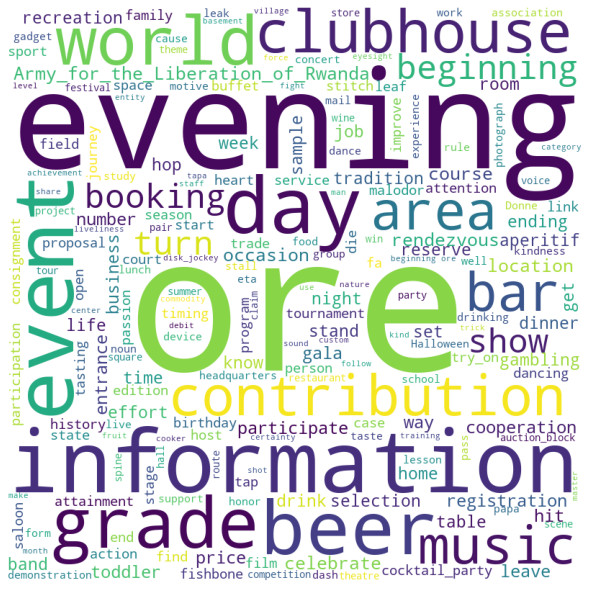

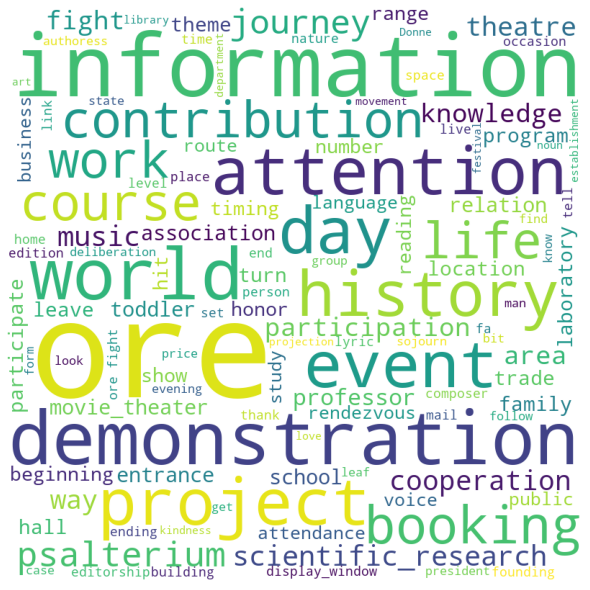

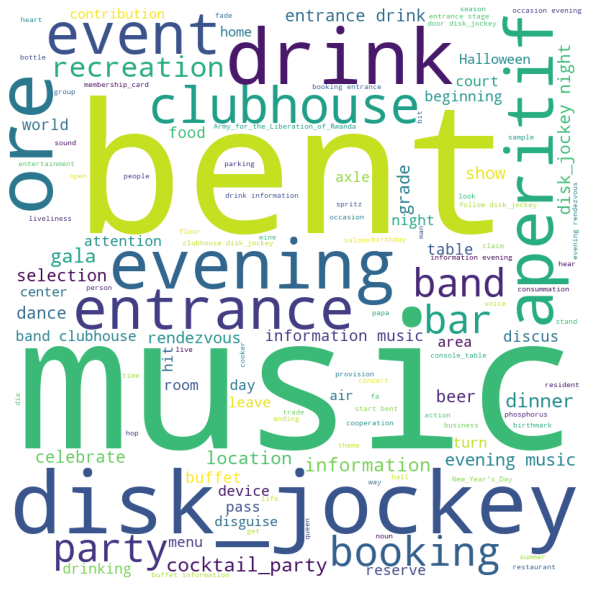

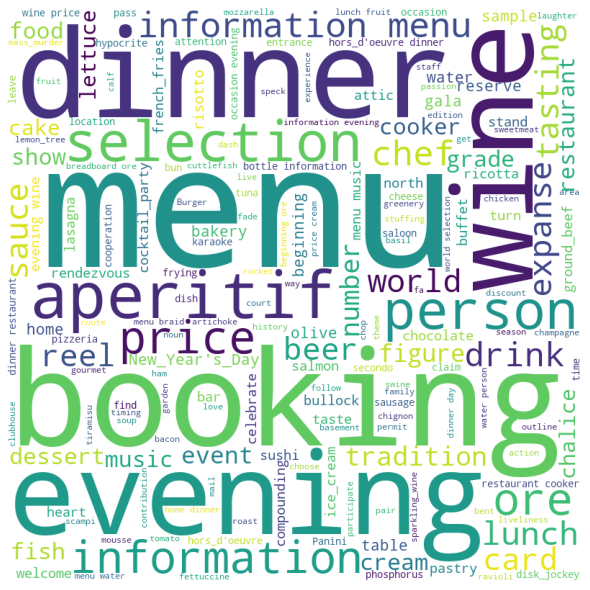

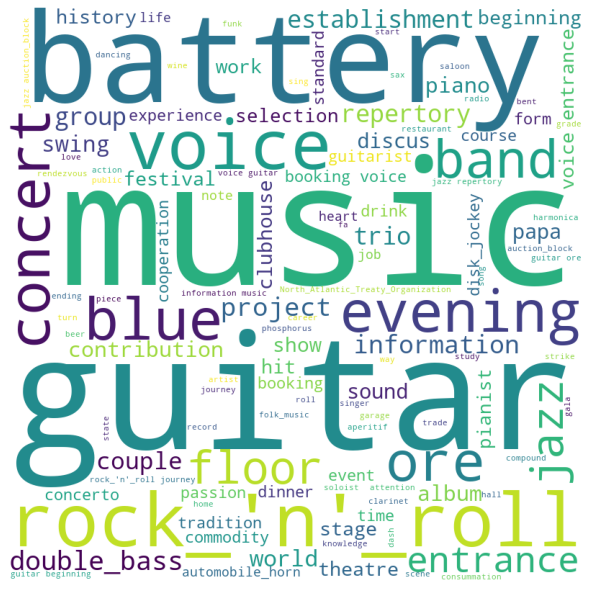

In [120]:
labels=km.labels_
cluster_labels = np.unique(labels)
cluster_sizes = [(labels == c).sum() for c in cluster_labels]
sizes_idx = np.argsort(cluster_sizes)[::-1][:5]
X1=new_df['wordnet_desc']
# Plot dei risultati
for i, c in enumerate(cluster_labels[sizes_idx]):
    mask = (labels == c)
    descrizioni_c = np.array(X1)[mask]
    text = " ".join(descrizioni_c)
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwordsTotali, 
                min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)

##Recommender System

In [121]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

def content_based_recommendation(event_index, content_matrix, num_recommendations):
    similarity = np.zeros(content_matrix.shape[0])
    for i in range(len(similarity)):
        similarity[i] = cosine_similarity(content_matrix[event_index], content_matrix[i])

    recommendation_indices = np.argsort(similarity)[::-1][1:num_recommendations+1]
    return recommendation_indices

In [122]:
num_events = new_df.shape[0]
num_recommendations = 5
recommendation_matrix = np.zeros((num_events, num_recommendations), dtype=int)
content_columns = ["culture", "music", "food", "fun"]
content_matrix = new_df[content_columns].values
for i in range(num_events):
    recommended_indices = content_based_recommendation(i, content_matrix, num_recommendations)
    recommendation_matrix[i, :] = recommended_indices

#np.savetxt("recommendation_matrix.csv", recommendation_matrix, delimiter=",", fmt='%d')
recommendation_matrix

array([[5583, 1672,  646, 4636, 5092],
       [1547, 1992, 5464, 2728, 1348],
       [4204,  137, 2428, 3788, 1909],
       ...,
       [2052, 1935, 2599, 4661,  254],
       [4818, 3211, 2328,  438, 5584],
       [3238, 3830, 2312, 4847, 4675]])

In [125]:
print('EVENTO PRESO IN ESAME: ')
ix = getRandomIndex(new_df)
print(new_df['text'][ix])
count = 1
for each in recommendation_matrix[ix]:
  print('EVENTO CONSIGLIATO NUMERO ' + str(count) + ': ')
  print(new_df['text'][each])
  print('\n\n')
  count = count + 1

EVENTO PRESO IN ESAME: 
Un altra favolosa serata al Queen...pieno di divertimento,musica e tanta allegria
EVENTO CONSIGLIATO NUMERO 1: 
Domenica 30 ottobre cover band Oasis e Liam Gallagher. https://instagram.com/oasis.liam_hellotribute?igshid=YmMyMTA2M2Y=

Lunedi 31 ottobre dj set 70'- 80'- 90'

in collaborazione con Aperol Spritz Italia



EVENTO CONSIGLIATO NUMERO 2: 
Serata di Halloween allOld Moon , 
MASCHERA OBBLIGATORIA 
Dj Set House 
Free entry e free food
 cocktail a partire da 5 , spritz 3.
Vieni a passare con noi la notte dei morti.

OLD MOON 
Circonvallazione Gianicolense 232



EVENTO CONSIGLIATO NUMERO 3: 
 TIME TO DRINK 

Another brick n the wall 

Lanno ormai ha ufficialmente preso il via e con lui i giovedi allinsegna del divertimento e della spensieratezza targati #MURO. 
Dopo il successo degli scorsi appuntamenti, vi aspettiamo all #ALTERNO Americanbar per sorseggiare ottimi drink e ascoltare buona musica. 

#PROMO
Beer 2
3 drink 10  
Shot vodka 2 
Wine 3 

Sound Mar